In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

/tmp/ipykernel_1796/1195567528.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     print('Текущее устройство - Gpu')
# else:
#     print('Текущее устройство - Cpu')
device = torch.device("cpu")

In [8]:
names = ['open_time', 'open_price', 'high_price', 'low_price', 'close_price',
         'volume', 'close_time', 'quote_time', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore']
#Open data and drop useless columns
data = []
filenames = []
for filename_1 in os.listdir('BTC'):
    for filename_2 in os.listdir('BTC/' + filename_1):
        df = pd.read_csv('BTC/' + filename_1 + '/' + filename_2)
        df.columns = names
        df.drop(columns=['open_time', 'close_time', 'quote_time', 'ignore'], axis=1, inplace=True)
        data.append(df)
        
#Make 1 big dataframe and save this as .csv
big_mommy = pd.concat(data)
big_mommy.to_csv('proccessed_BTC_2020-2023.csv', index=False)

In [9]:
df = pd.read_csv('proccessed_BTC_2020-2023.csv')
print(df.head(2))

   open_price  high_price  low_price  close_price      volume  count  \
0    57545.06    57549.99   57421.05     57542.62  139.034744   4106   
1    57542.64    57719.82   57542.62     57703.10   84.742481   2488   

   taker_buy_volume  taker_buy_quote_volume  
0         62.627884            3.600659e+06  
1         39.257872            2.262959e+06  


In [10]:
#Получаем входные данные и метки
#(модель предсказывает на 6 часов вперед используя прошлые 48 часов, интервал - 1 минута)
input = df.copy()
input.drop(['close_price', 'taker_buy_quote_volume'], axis=1, inplace=True) 
input = input.iloc[:-360]
labels = df.copy()['close_price'].iloc[2880:]
print(len(input))
print(labels.size)
print(input.head(3))

2101107
2098587
   open_price  high_price  low_price      volume  count  taker_buy_volume
0    57545.06    57549.99   57421.05  139.034744   4106         62.627884
1    57542.64    57719.82   57542.62   84.742481   2488         39.257872
2    57702.87    57745.94   57696.75   47.611925   2188         20.777537


In [11]:
#Normalization
need_normalize = ['volume', 'count', 'taker_buy_volume']
for el in need_normalize:
    input[el] = (input[el] - input[el].mean()) / input[el].std()

In [ ]:
#Feature engineering
#Арун=[(period-after_max)/period]·100

In [12]:
#Data loader
class Custom_dataset(Dataset):
    def __init__(self, input, labels, shuffle=False):
        self.input = []
        self.labels = []
        for i in range(2880, len(input), 180):
            self.input.append(input.iloc[i-2880:i].values.tolist())
        print('Length of input data: ' + str(len(self.input)))
        for i in range(360, labels.size, 180):
            self.labels.append(labels.iloc[i-360:i].values.tolist())
        print('Length of labels: ' + str(len(self.labels)))
        self.input = torch.tensor(self.input, dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.float32)
        if shuffle:
            indices = torch.randperm(len(self.input))
            self.input = self.input[indices]
            self.labels = self.labels[indices]
            print('Shuffled: True')
        else:
            print('Shuffled: False')

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        return self.input[idx], self.labels[idx]  

custom_dataset = Custom_dataset(input, labels, shuffle=True)
# custom_dataloader = DataLoader(custom_dataset, batch_size=128)

Length of input data: 11657
Length of labels: 11657
Shuffled: True


In [13]:
from torch.utils.data.dataset import random_split

#60% - training
#20% - validate
#20% - testing
train_dataset_size = int(len(custom_dataset) * 0.6)
validate_dataset_size = int(len(custom_dataset) * 0.2)
testing_dataset_size = len(custom_dataset) - train_dataset_size- validate_dataset_size
train_subset, validate_subset, testing_subset = random_split(custom_dataset, [train_dataset_size, validate_dataset_size, testing_dataset_size])
print(len(train_subset))
print(len(validate_subset))
print(len(testing_subset))
print(f'Train batches: {len(train_subset) / 128}')
print(f'Validate batches: {len(validate_subset) / 128}')
print(f'Testing batches: {len(testing_subset) / 128}')
train_dataloader = DataLoader(train_subset, batch_size=128)
validate_dataloader = DataLoader(validate_subset, batch_size=128)
testing_dataloader = DataLoader(testing_subset, batch_size=128)
print(f'Train real batches: {len(train_dataloader)}')
print(f'Validate real batches: {len(validate_dataloader)}')
print(f'Testing real batches: {len(testing_dataloader)}')

6994
2331
2332
Train batches: 54.640625
Validate batches: 18.2109375
Testing batches: 18.21875
Train real batches: 55
Validate real batches: 19
Testing real batches: 19


In [14]:
#Parametric relu
class PReLU(nn.Module):
    def __init__(self, num_parameters=1, init=0.25):
        super(PReLU, self).__init__()
        self.alpha = nn.Parameter(torch.Tensor(num_parameters).fill_(init))

    def forward(self, x):
        pos = torch.relu(x)
        neg = self.alpha * ((x - torch.abs(x)) * 0.5)
        return pos + neg

#Модель 1
#Input shape = (x, 2880, 6)
#Labels shape = (y, 360)
class Model_1(nn.Module):
    def __init__(self):
        super(Model_1, self).__init__()
        # 1-й слой: входные данные, размерность 12
        self.flatten = nn.Flatten()
        self.linear_prelu_stack = nn.Sequential(
            nn.Linear(2880 * 6, 256),
            # 2-й слой: 64 нейрона, функция активации 'relu'
            PReLU(num_parameters=256),
            # nn.ReLU(),
            # 3-й слой: 32 нейрона, функция активации 'relu'
            nn.Linear(256, 128),
            # nn.ReLU(),
            PReLU(num_parameters=128),
            # 4-й слой: 16 нейронов, без функции активации, 1 выход
            nn.Linear(128, 128),
            # nn.ReLU(),
            PReLU(num_parameters=128),
            nn.Linear(128, 360)
        )

    def forward(self, x):
        # Прямой проход через слои
        x = self.flatten(x)
        x = self.linear_prelu_stack(x)
        return x
    
def validate(model, validate_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in validate_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    average_loss = total_loss / len(validate_loader)
    return average_loss

class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=True):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, loss):
        if self.best_score is None:
            self.best_score = loss
        elif loss > self.best_score - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = loss
            self.counter = 0

        return self.early_stop

In [17]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = Model_1()
print(model)
criterion = nn.L1Loss()#nn.MSELoss()#nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.01) #RMSprop слишком инертен
model.to(device)
epochs = 300
history = []
early_stopping = EarlyStopping(patience=12, delta=70)

# Конфигурирование ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
# Пример цикла обучения
best_loss = float('inf')  # Инициализация лучшей потери

#Обучение
for epoch in range(epochs):
    model.train(True)
    running_loss = 0.0
    for inp, targ in train_dataloader:
        outputs = model(inp)
        loss = criterion(outputs, targ)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Валидация и обновление learning rate
        val_loss = validate(model, validate_dataloader, criterion)

        # Сохранение лучшей модели
        if loss.item() < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), 'best_model_0.1.pth')
    
    average_loss = running_loss / len(train_dataloader)
    # Проверка EarlyStopping
    if early_stopping(average_loss):
        print("Early stopping")
        break
    history.append(average_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss train: {average_loss}, Loss validate: {val_loss}")
    lr_scheduler.step(val_loss)

print("Обучение завершено")#71

Model_1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_prelu_stack): Sequential(
    (0): Linear(in_features=17280, out_features=256, bias=True)
    (1): PReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): PReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): PReLU()
    (6): Linear(in_features=128, out_features=360, bias=True)
  )
)
Epoch 1/300, Loss train: 120031.61853693181, Loss validate: 17179.003238075657
Epoch 2/300, Loss train: 5205.2426868785515, Loss validate: 3074.3264931126646
Epoch 3/300, Loss train: 2769.9000510475853, Loss validate: 2273.347264340049
Epoch 4/300, Loss train: 2043.2883755770597, Loss validate: 880.3207140470806
Epoch 5/300, Loss train: 2553.1339266690343, Loss validate: 2472.0010022615133
Epoch 6/300, Loss train: 1917.8998901367188, Loss validate: 2025.2002402857731
Epoch 7/300, Loss train: 2835.006071333452, Loss validate: 9118.915296052632
Epoch 8/300, Loss train: 2211.457674893466, Loss vali

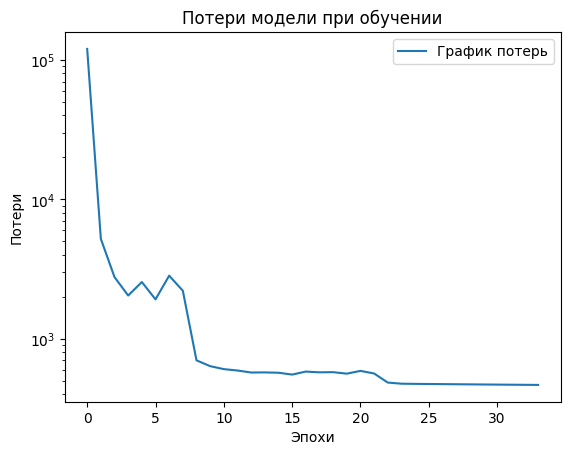

In [18]:
import matplotlib.pyplot as plt

# Строим график
plt.plot([el for el in range(len(history))], history, label='График потерь')

# Добавляем заголовок и метки осей
plt.title('Потери модели при обучении')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.yscale('log')

# Добавляем легенду
plt.legend()

# Показываем график
plt.show()

In [41]:
#Epoch 99/100, Loss train: 11740.796759588067, Loss validate: 17755.860034839527
#Epoch 45/300, Loss train: 11782.044504616477, Loss validate: 17750.228568412163
#Epoch 121/300 Loss train: ~14540.1045404607, Loss validate: 13025.983556798987
#Перемешивание данных
#Epoch 40/300, Loss train: 12420.102796519886, Loss validate: 12372.684200802365
#Epoch 46/300, Loss train: 12455.469833096591, Loss validate: 12360.698638091217 Dropout=0.2
#Epoch 84/300, Loss train: 12411.495880681818, Loss validate: 12361.870513091217 Dropout=0.5 /После функции активации
#Epoch 94/300, Loss train: 12410.738893821022, Loss validate: 12362.056059966217 Dropout=0.5 /До функции активации + изменены patience
#Можно сделать вывод о том, что dropout увеличивает только количество эпох для наступления переобучения.
#аким образом его следует использовать только в том случае, если переобучение наступает слишком быстро.

#Убрав бессмысленный большой параметр и использовав prelu, получилось следующее:
#Epoch 18/300, Loss train: 536.1260725541548, Loss validate: 477.21559926625844
#С простым relu:
#Epoch 21/300, Loss train: 448.62574157714846, Loss validate: 477.84757500725823
#=> какого-то "умертвления" нейронов в данной модели не происходит
#С нормализацией данных + prelu, поскольку нормализованные данные мб < 0
#Epoch 22/300, Loss train: 456.11132562810724, Loss validate: 476.1366717364337
#Epoch 34/300, Loss train: 466.57342917702414, Loss validate: 439.2744349429482 (patience = 12)

[8502286.063565342, 24471.430379971593, 24315.20026633523, 24237.977627840908, 24105.769282670455, 23995.333948863637, 23782.918128551137, 23820.7400390625, 23446.869788707387, 23447.49552556818, 23238.697247869317, 23172.961629971593, 22980.01036931818, 22968.695472301137, 22668.297531960226, 22466.384898792614, 22465.77137784091, 22200.831560724433, 22116.805024857953, 21881.958096590908, 21801.186381392046, 21814.715651633524, 21538.032990056818, 21403.217631392046, 21311.688245738635, 21269.486044034093, 20839.420161576705, 20628.387859552557, 20611.462943892046, 20558.705291193182, 20271.26788884943, 20049.128462357956, 19964.216938920454, 19778.51698330966, 19525.55964133523, 19209.543492542613, 19213.303773082385, 18842.12754794034, 18705.32381036932, 18398.881374289773, 18223.252183948865, 17933.207848011363, 17695.547345525567, 17418.255841619317, 17143.208584872158, 16759.965188876064, 16562.0419921875, 16302.713893821023, 16046.86084428267, 15835.453653231534, 15831.81790660

torch.Size([1, 2880, 6])


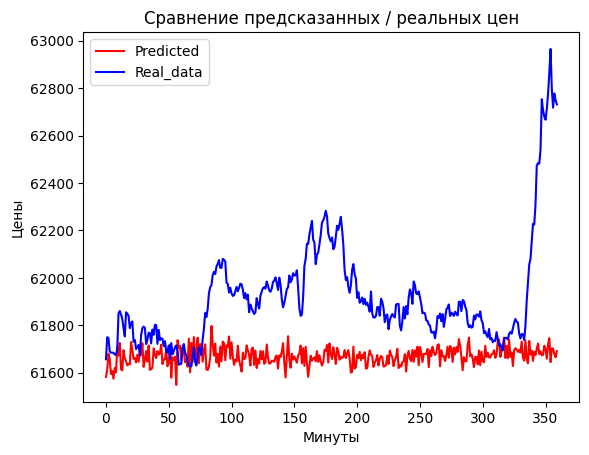

In [19]:
import matplotlib.pyplot as plt

criterion = nn.L1Loss()
loaded_model = Model_1()
loaded_model.load_state_dict(torch.load('best_model_0.1.pth'))
loaded_model.eval()
output = None
test = None
for test_input, test_labels in testing_dataloader.dataset:
    batched_input = test_input.unsqueeze(0)
    print(batched_input.shape)
    output = loaded_model(batched_input)
    test = test_labels
    break

plt.plot([el for el in range(360)], output.squeeze().tolist()[:360], color='red', label='Predicted')
plt.plot([el for el in range(360)], test.tolist()[:360], color='blue', label='Real_data')
plt.title('Сравнение предсказанных / реальных цен')
plt.xlabel('Минуты')
plt.ylabel('Цены')
# #Логарифмируем графики
# plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()